In [ ]:
import jax.random
import numpy as np
!pip install -U jax[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability
!pip install tensorflow-datasets
!pip install imbalanced-learn
!pip install -U git+https://github.com/Habush/Sklearn-genetic-opt.git
!pip install lark==1.1.2
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt-get -y install swig
!pip install smac

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.23-py3-none-any.whl size=1273267 sha256=6026d7ae320933c4bacdb0ec24ca5d5ef71de27f3951855d618907a3bd925dc0
  Stored in directory: /root/.cache/pip/wheels/37/a7/a2/4596a41cd9ab3b60374936121a2ff9d5fae62468e9dc95e7fb
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.7/160.7 MB 9.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.c

In [1]:
# Install asmoses and its dependencies
# !apt-get update
# !apt-get install -y guile-3.0 guile-3.0-dev
# !./ocbld cogutil atomspace ure asmoses

In [5]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 0

In [6]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
from nn_util import *
from nn_models import *
from gibbs_sampler import *
from sgmcmc import *

plt.style.use('ggplot')
%load_ext autoreload

/home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [7]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [8]:
tamox_df = pd.read_csv(f"{data_dir}/tamoxBinaryEntrez.csv")
tamox_df.head()

,posOutcome,4111,4110,10661,131,4438,330,1109,2637,2642,...,7634,55769,7637,7644,741,54993,79364,7791,23140,26009
0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,1
2,0,0,0,0,1,0,0,1,1,1,...,0,0,0,1,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0


In [9]:
regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])
print(f"Total interactions: {regnet_df.shape[0]}")
regnet_df.head()

Total interactions: 372774


/tmp/ipykernel_4868/3470585798.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  regnet_df = pd.read_table(f"{data_dir}/human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])


,REGULATOR SYMBOL,REGULATOR ID,TARGET SYMBOL,TARGET ID
0,USF1,7391,S100A6,6277
1,USF1,7391,DUSP1,1843
2,USF1,7391,C4A,720
3,USF1,7391,ABCA1,19
4,TP53,7157,TP73,7161


In [11]:
net_intr = pd.Series(regnet_df["REGULATOR ID"].values, index=regnet_df["TARGET ID"])
net_intr_rev = pd.Series(regnet_df["TARGET ID"].values, index=regnet_df["REGULATOR ID"])
X_df, y_df = tamox_df[tamox_df.columns.difference(["posOutcome"])], tamox_df["posOutcome"]

### Fisher Test

In [131]:
seed = 196
rng_key = jax.random.PRNGKey(seed)

In [132]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df, test_size=0.3)

In [133]:
# idx_sig = fisher_exact_test(X_train_df, y_train_df, thres=0.01).ravel()
# np.save(f"{data_dir}/exp_data_4/idx_sig_s_{seed}.npy", idx_sig)
# len(idx_sig)

In [134]:
idx_sig = np.load(f"{data_dir}/exp_data_4/cancer/fisher/fisher_idx_sig_{seed}.npy")
len(idx_sig)

668

In [135]:
X_train_sig, X_test_sig = X_train_df.iloc[:,idx_sig], X_test_df.iloc[:, idx_sig]
J = build_network(X_train_sig, net_intr, net_intr_rev)
p = J.shape[0]
print(np.count_nonzero(J) // 2)

31


In [136]:
X_train, X_test, y_train, y_test = X_train_sig.to_numpy(), X_test_sig.to_numpy(), \
                                   y_train_df.to_numpy(), y_test_df.to_numpy()

X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                   jax.device_put(y_train), jax.device_put(y_test)

In [137]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

### Logistic Regression & SVM

In [138]:
from sklearn.linear_model import LogisticRegression
log_param_grid = {"C": np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=0,
                           scoring="roc_auc", cv=cv).fit(X_train, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000,  **log_grid_cv.best_params_)
log_cv_score_1 = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
log_test_score_1 = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"cv score: {log_cv_score_1}, test_score: {log_test_score_1}")

{'C': 0.021544346900318832}
cv score: 0.8617579642579642, test_score: 0.7174813347544269


In [139]:
from sklearn.svm import SVC
svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=0,
                           scoring="roc_auc", cv=cv).fit(X_train, y_train)
print(svc_grid_cv.best_params_)
clf = SVC(probability=True,  **svc_grid_cv.best_params_)
svc_cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
svc_test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"cv score: {svc_cv_score}, test_score: {svc_test_score}")

{'C': 2.154434690031882, 'degree': 2, 'kernel': 'rbf'}
cv score: 0.8694638694638694, test_score: 0.7223142605988374


### BNN

In [18]:
from smac.facade.smac_mf_facade import SMAC4MF
from smac.scenario.scenario import Scenario

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration


def get_configspace(layer_dims)-> ConfigurationSpace:
    # Build Configuration Space which defines all parameters and their ranges.

    cs  = ConfigurationSpace()

    layer_dim = CategoricalHyperparameter("layer_dim", layer_dims, default_value=layer_dims[0])
    activation = CategoricalHyperparameter("activation", ["relu", "tanh"], default_value="tanh")
    # lr_schedule = CategoricalHyperparameter("lr_schedule", ["cyclical"], default_value="cyclical")
    disc_lr = UniformFloatHyperparameter("disc_lr", lower=1e-5, upper=0.8, log=True)
    contin_lr = UniformFloatHyperparameter("contin_lr", lower=1e-5, upper=1e-2, log=True)
    cycle_len = UniformIntegerHyperparameter("cycle_len", lower=4, upper=20)
    beta = UniformFloatHyperparameter("beta", lower=0.3, upper=0.9)
    batch_sze = CategoricalHyperparameter("batch_size", [32, 64, 128], default_value=32)

    eta = UniformFloatHyperparameter("eta", lower=1e-3, upper=10, log=True)
    mu = UniformFloatHyperparameter("mu", lower=1e-3, upper=10, log=True)
    temp = UniformFloatHyperparameter("temp", lower=1e-3, upper=1, log=True)
    sigma = UniformFloatHyperparameter("sigma", lower=1., upper=10)
    # Add hyper-parameters
    cs.add_hyperparameters([layer_dim ,disc_lr, contin_lr,beta, eta, mu, activation, temp, cycle_len, sigma, batch_sze])

    # # Cyclical SG-MCMC condition
    # use_cycle_len = InCondition(child=cycle_len, parent=lr_schedule, values=["cyclical"])
    # use_beta = InCondition(child=beta, parent=lr_schedule, values=["cyclical"])
    #
    # cs.add_conditions([use_cycle_len, use_beta])

    return cs



def generate_train_cs(seed, X, y, J):
    def train_cs(config: Configuration, budget: int)-> float:
        params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
                  "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                  "sigma": config["sigma"], "cycle_len": config["cycle_len"], "beta": config["beta"]}
        # print(seed)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        sgmcmc = MixedSGMCMC(seed=seed, n_samples=budget, n_warmup=0,
                             n_chains=1, layer_dims=[config["layer_dim"]], **params)
        cv_score = np.mean(cross_val_score(sgmcmc, X, y,  cv=cv, fit_params={
            "activation_fns": [config["activation"]], "J": J
        }))

        return 1 - cv_score


    return train_cs


def optimize_hyper_parameters(seed, X, y, J, total_time=120):


    layer_dims = [350, 450, 500, 550, 600, 650]
    # print(layer_dims)

    cs = get_configspace(layer_dims)
    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 3,  # runtime limit for the target algorithm
    })

    max_steps = 2000

    train_cs = generate_train_cs(seed, X, y, J)

    intensifier_kwargs = {"initial_budget": 2000, "max_budget": max_steps}

    smac = SMAC4MF(scenario=scenario, rng=np.random.RandomState(seed),
                   tae_runner=train_cs, intensifier_kwargs=intensifier_kwargs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, budget=max_steps, seed=seed)

    return incumbent, 1 - inc_val[1]

In [141]:
config, bnn_cv_score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=180)
bnn_cv_score

[500, 550, 600, 650]


/usr/local/lib/python3.9/dist-packages/smac/intensification/parallel_scheduling.py:154: UserWarning: Hyperband is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(


0.8659168312437812

In [142]:
config

Configuration(values={
  'activation': 'tanh',
  'batch_size': 128,
  'beta': 0.23969475754150923,
  'contin_lr': 1.7457234325598905e-05,
  'cycle_len': 27,
  'disc_lr': 7.97381012761173e-05,
  'eta': 0.002641379543353128,
  'layer_dim': 600,
  'lr_schedule': 'cyclical',
  'mu': 1.027542495257716,
  'sigma': 1.178357765216934,
  'temp': 0.06937508002225257,
})

In [148]:
%autoreload
from sgmcmc import MixedSGMCMC
params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
          "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
          "beta": config["beta"], "sigma": config["sigma"],
          "lr_schedule": config["lr_schedule"], "cycle_len": config["cycle_len"]}

sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_warmup=500, n_chains=1,
                     layer_dims=[config["layer_dim"]], **params)

sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=J)

sgmcmc.score(X_test, y_test)

2022-10-31 17:52:15.333749: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 764.46MiB (801600000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.92MiB
              constant allocation:        16B
        maybe_live_out allocation:    1.50GiB
     preallocated temp allocation:    5.69MiB
  preallocated temp fragmentation:   173.3KiB (2.97%)
                 total allocation:    1.51GiB
Peak buffers:
	Buffer 1:
		Size: 764.46MiB
		XLA Label: copy
		Shape: f32[500,1,668,600]

	Buffer 2:
		Size: 764.46MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1, 668, 600) broadcast_dimensions=()]" source_file="/notebooks/gibbs_sampler.py" source_line=290
		XLA Label: broadcast
		Shape: f32[500,1,668,600]

	Buffer 3:
		Size: 1.70MiB
		Entry Parameter Subshape: f32[668,668]

	Buffer 

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 764.46MiB (801600000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.92MiB
              constant allocation:        16B
        maybe_live_out allocation:    1.50GiB
     preallocated temp allocation:    5.69MiB
  preallocated temp fragmentation:   173.3KiB (2.97%)
                 total allocation:    1.51GiB
Peak buffers:
	Buffer 1:
		Size: 764.46MiB
		XLA Label: copy
		Shape: f32[500,1,668,600]
		==========================

	Buffer 2:
		Size: 764.46MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1, 668, 600) broadcast_dimensions=()]" source_file="/notebooks/gibbs_sampler.py" source_line=290
		XLA Label: broadcast
		Shape: f32[500,1,668,600]
		==========================

	Buffer 3:
		Size: 1.70MiB
		Entry Parameter Subshape: f32[668,668]
		==========================

	Buffer 4:
		Size: 1.53MiB
		Entry Parameter Subshape: f32[1,668,600]
		==========================

	Buffer 5:
		Size: 1.53MiB
		Entry Parameter Subshape: f32[1,668,600]
		==========================

	Buffer 6:
		Size: 1.53MiB
		XLA Label: copy
		Shape: f32[1,668,600]
		==========================

	Buffer 7:
		Size: 1.53MiB
		XLA Label: copy
		Shape: f32[1,668,600]
		==========================

	Buffer 8:
		Size: 1.27MiB
		XLA Label: copy
		Shape: f32[500,1,668]
		==========================

	Buffer 9:
		Size: 1.27MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1, 668) broadcast_dimensions=()]" source_file="/notebooks/gibbs_sampler.py" source_line=290
		XLA Label: broadcast
		Shape: f32[500,1,668]
		==========================

	Buffer 10:
		Size: 1.14MiB
		XLA Label: copy
		Shape: f32[500,1,600,1]
		==========================

	Buffer 11:
		Size: 1.14MiB
		XLA Label: copy
		Shape: f32[500,1,600]
		==========================

	Buffer 12:
		Size: 1.14MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1, 600, 1) broadcast_dimensions=()]" source_file="/notebooks/gibbs_sampler.py" source_line=290
		XLA Label: broadcast
		Shape: f32[500,1,600,1]
		==========================

	Buffer 13:
		Size: 1.14MiB
		Operator: op_name="jit(scan)/jit(main)/broadcast_in_dim[shape=(500, 1, 600) broadcast_dimensions=()]" source_file="/notebooks/gibbs_sampler.py" source_line=290
		XLA Label: broadcast
		Shape: f32[500,1,600]
		==========================

	Buffer 14:
		Size: 1.14MiB
		Entry Parameter Subshape: s32[449,668]
		==========================

	Buffer 15:
		Size: 785.2KiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(inner_step)/vmap(jit(one_step))/threefry2x32" source_file="/usr/local/lib/python3.9/dist-packages/blackjax/util.py" source_line=80
		XLA Label: broadcast
		Shape: u32[1,201001]
		==========================



In [17]:
# sgmcmc_best_params = {'eta': 0.5391545611234205,
#                       'mu': 0.10499762621756892,
#                       'temp': 0.529923738911503,
#                       'sigma': 1.5411655334603958}
#
#
# mixed_sgmcmc = MixedSGMCMC(seed=seed, lr_schedule="cyclical", n_samples=4000, n_chains=1, disc_lr=1e-1, contin_lr=1e-5,
#                            batch_size=20, layer_dims=[400], cycle_len=10, **sgmcmc_best_params)
#
# bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv, fit_params={"J": J, "activation_fns": ["tanh"]}))
# mixed_sgmcmc.fit(X_train, y_train, J=J, activation_fns=["tanh"])
# bnn_test_score = mixed_sgmcmc.score(X_test, y_test)
# print(f"cv_score: {bnn_cv_score}, test_score: {bnn_test_score}")

cv_score: 0.7960702906425968, test_score: 0.7336370979403082


In [147]:
gamma_means = jnp.mean(sgmcmc.states_.discrete_position, axis=0)
# np.save(f"{data_dir}/exp_data_4/cancer/sgmcmc_gamma_mean_fisher_s_{seed}.npy", gamma_means)

AttributeError: 'MixedSGMCMC' object has no attribute 'states_'

Text(0, 0.5, 'num features')

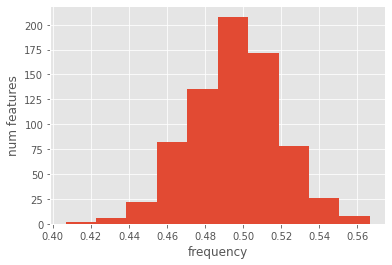

In [101]:
plt.hist(gamma_means)
plt.xlabel("frequency")
plt.ylabel("num features")

In [118]:
gamma_idx = jnp.argsort(gamma_means)[::-1][:100]

In [127]:
gamma_idx = jnp.argwhere(gamma_means > 0.50).ravel()
len(gamma_idx)

306

In [128]:
# %autoreload
# from run_nn_cosmic_exp import run_logistic_regression

_, log_cv_score, log_test_score = run_logistic_regression(X_train, X_test, y_train, y_test, cv, feats=gamma_idx)
print(log_cv_score)
print(log_test_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8357012432012432
0.6585197215079357


In [63]:
sel_entrz_id = []
if not SERVER:
    sel_entrz_id = X_train_sig.iloc[:,gamma_idx].columns.to_list()
    with open(f"{data_dir}/exp_data_4/cancer/sel_entrz_fisher_id_s_{seed}.txt", "w") as fp:
        for i in sel_entrz_id:
            fp.write(f"{i}\n")
else:

    with open(f"{data_dir}/exp_data_4/cancer/sel_entrz_fisher_id_s_{seed}.txt", "r") as fp:
        for line in fp.readlines():
            sel_entrz_id.append(line.strip())

len(sel_entrz_id)

52

### Run MOSES

In [64]:
X_train_sel, X_test_sel = X_train_df.loc[:, sel_entrz_id], X_test_df.loc[:, sel_entrz_id]
X_train_sel.shape

(449, 52)

In [21]:
%autoreload
from moses_estimator import *

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

moses_est = MosesEstimator(seed=1234, num_models=100, num_evals=1000, prob="it")


moses_grid_cv = GridSearchCV(estimator=moses_est, param_grid=moses_grid_params, verbose=3,
                             cv=cv, n_jobs=-1).fit(X_train_sel, y_train_df, output_label="posOutcome")

print(moses_grid_cv.best_params_)
print(moses_grid_cv.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 2/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.3, hc_fraction_nn=0.01;, score=0.693 total time=   3.1s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.6, hc_fraction_nn=0.01;, score=0.708 total time=   3.8s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=10.0, diversity_pressure=0.9, hc_fraction_nn=0.1;, score=0.704 total time=   3.6s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=31.622776601683793, diversity_pressure=0.3, hc_fraction_nn=0.01;, score=0.714 total time=   3.0s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=31.622776601683793, diversity_pressure=0.6, hc_fraction_nn=0.1;, score=0.723 total time=   3.1s
[CV 2/5] END complexity_ratio=1.0, complexity_temp=100.0, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.685 total time=   3.3s
[CV 3/5] END complexity_ratio=1.0, complexity_temp=100.0, diversity_pressure=0.3, hc_fraction_nn=0.1;, sc

In [65]:
%autoreload
from moses_estimator import *
moses_best_params = {'complexity_ratio': 177.82794100389228, 'complexity_temp': 100.0, 'diversity_pressure': 0.9, 'hc_fraction_nn': 0.1}

moses_est = MosesEstimator(seed=1234, num_models=100, num_evals=1000,
                           prob="it", **moses_best_params)
cv_score = cross_val_score(moses_est, X_train_sel, y_train_df, cv=cv, fit_params={"output_label": "posOutcome"}, n_jobs=-1)
print(np.mean(cv_score))
moses_est.fit(X_train_sel, y_train_df, output_label="posOutcome")
moses_est.score(X_test_sel, y_test_df)


0.7396008158508158


0.7196216514774924

In [66]:
moses_est.models_[0].model

'or(and(or(and(!$f6576 !$f10683) $f6672) or(!$f1820 !$f10683)) and(!$f8618 !$f80153 !$f80255) !$f6657)'

In [67]:
import pickle
#
# with open(f"{data_dir}/exp_data_4/moses_best_params_s_1234_fisher.pickle", "wb") as fp:
#     pickle.dump(moses_grid_cv.best_params_, fp, protocol=pickle.HIGHEST_PROTOCOL)
train_eval_out = moses_est._eval_models(moses_est.models_, assign_cols(X_train_sel)).T
test_eval_out = moses_est._eval_models(moses_est.models_, assign_cols(X_test_sel)).T

In [68]:
X_train_sel_moses = np.concatenate([X_train_sel.to_numpy(), train_eval_out], axis=1)
X_test_sel_moses = np.concatenate([X_test_sel.to_numpy(), test_eval_out], axis=1)
X_train_sel_moses

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [69]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_2 = np.mean(cross_val_score(clf, X_train_sel, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel, y_train)
log_test_score_2 = roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:,1])
print(f"cv score: {log_cv_score_2}, test_score: {log_test_score_2}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.790 total time=   0.2s
[CV 2/5] END ............................C=0.01;, score=0.898 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.884 total time=   0.2s
[CV 4/5] END ............................C=0.01;, score=0.833 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.778 total time=   0.1s
[CV 1/5] END ............C=0.021544346900318832;, score=0.799 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.903 total time=   0.1s
[CV 3/5] END ............C=0.021544346900318832;, score=0.890 total time=   0.0s
[CV 4/5] END ............C=0.021544346900318832;, score=0.829 total time=   0.1s
[CV 5/5] END ............C=0.021544346900318832;, score=0.776 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.810 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

In [70]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel_moses, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_3 = np.mean(cross_val_score(clf, X_train_sel_moses, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel_moses, y_train)
log_test_score_3 = roc_auc_score(y_test, clf.predict_proba(X_test_sel_moses)[:,1])
print(f"cv score: {log_cv_score_3}, test_score: {log_test_score_3}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.837 total time=   0.2s
[CV 2/5] END ............................C=0.01;, score=0.879 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.848 total time=   0.3s
[CV 4/5] END ............................C=0.01;, score=0.811 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.749 total time=   0.0s
[CV 1/5] END ............C=0.021544346900318832;, score=0.838 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.883 total time=   0.1s
[CV 3/5] END ............C=0.021544346900318832;, score=0.859 total time=   0.2s
[CV 4/5] END ............C=0.021544346900318832;, score=0.810 total time=   0.0s
[CV 5/5] END ............C=0.021544346900318832;, score=0.744 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.834 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

In [71]:
result_summary_dict = {}
result_summary_dict["classifier"] = ["LR", "SVM", "BNN", "BNN + LR", "BNN + MOSES + LR"]
result_summary_dict["num_feats"] = [len(idx_sig), len(idx_sig), len(idx_sig), len(sel_entrz_id), X_train_sel_moses.shape[1]]
result_summary_dict["cv_score"] = [log_cv_score_1, svc_cv_score, 0.7960702906425968, log_cv_score_2, log_cv_score_3]
result_summary_dict["test_score"] = [log_test_score_1, svc_test_score, 0.7336370979403082, log_test_score_2, log_test_score_3]

result_summary_df = pd.DataFrame(result_summary_dict)
result_summary_df

,classifier,num_feats,cv_score,test_score
0,LR,633,0.813986,0.732947
1,SVM,633,0.841381,0.729495
2,BNN,633,0.796070,0.733637
3,BNN + LR,52,0.839959,0.691936
4,BNN + MOSES + LR,152,0.826750,0.711406


## Higher-Order R/nships

In [35]:
J_3 = np.linalg.matrix_power(J, 3)
np.fill_diagonal(J_3, 0.0)
np.count_nonzero(J_3) // 2

126

In [30]:
%autoreload
from sgmcmc import MixedSGMCMC
from sklearn_genetic.callbacks import ProgressBar
from sklearn_genetic.callbacks import DeltaThreshold, TimerStopping
delta_callback = DeltaThreshold(threshold=0.001, generations=3, metric='fitness')
timer_callback = TimerStopping(total_seconds=600)
progres_callback = ProgressBar()
mixed_sgmcmc_2 = MixedSGMCMC(seed=seed, n_samples=2000, n_chains=1,
                           lr_schedule="cyclical", batch_size=20, cycle_len=10, layer_dims=[400])
evolved_grid_cv_2 = GASearchCV(estimator=mixed_sgmcmc_2, cv=cv,
                             param_grid=param_grid, verbose=True, population_size=10, generations=4).fit(X_train, y_train, callbacks=[progres_callback, delta_callback],  J=J_3, activation_fns=["tanh"])


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:3326: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.743985	0.0223109  	0.771553   	0.694054   
1  	20    	0.75633 	0.0140871  	0.771553   	0.726044   
2  	20    	0.770768	0.00744722 	0.781274   	0.763044   
3  	20    	0.772425	0.00843626 	0.781274   	0.761707   
4  	20    	0.774382	0.0079803  	0.781274   	0.763044   


NameError: name 'pickle' is not defined

In [32]:
import pickle
with open(f"{data_dir}/exp_data_4/sgmcmc_best_params_s_1234_fisher_v2.pickle", "wb") as fp:
    pickle.dump(evolved_grid_cv_2.best_params_, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
print(evolved_grid_cv_2.best_params_)

{'eta': 9.787025560105304, 'mu': 2.038813937584637, 'temp': 0.7748105657618165, 'sigma': 0.9744657194360173}


In [26]:
%autoreload

sgmcmc_best_params_2 = {'eta': 9.787025560105304,
                        'mu': 2.038813937584637,
                        'temp': 0.7748105657618165,
                        'sigma': 0.9744657194360173}

mixed_sgmcmc_2 = MixedSGMCMC(seed=seed, lr_schedule="cyclical", n_samples=2000, n_chains=1, disc_lr=1e-1, contin_lr=1e-5,
                           batch_size=20, layer_dims=[400], cycle_len=10, **sgmcmc_best_params_2)

bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc_2, X_train, y_train, cv=cv, fit_params={"J": J_3, "activation_fns": ["tanh"]}))
mixed_sgmcmc_2.fit(X_train, y_train, J=J_3, activation_fns=["tanh"])
bnn_test_score = mixed_sgmcmc_2.score(X_test, y_test)
print(f"cv_score: {bnn_cv_score}, test_score: {bnn_test_score}")

cv_score: 0.7788946877388406, test_score: 0.7259044249983657


In [40]:
gamma_means_2 = jnp.mean(mixed_sgmcmc_2.states_.discrete_position, axis=0)
np.save(f"{data_dir}/exp_data_4/cancer/sgmcmc_gamma_mean_fisher_s_{seed}_v2.npy", gamma_means_2)

In [36]:
gamma_means_2 = np.load(f"{data_dir}/exp_data_4/cancer/sgmcmc_gamma_mean_fisher_s_{seed}_v2.npy")

Text(0, 0.5, 'num features')

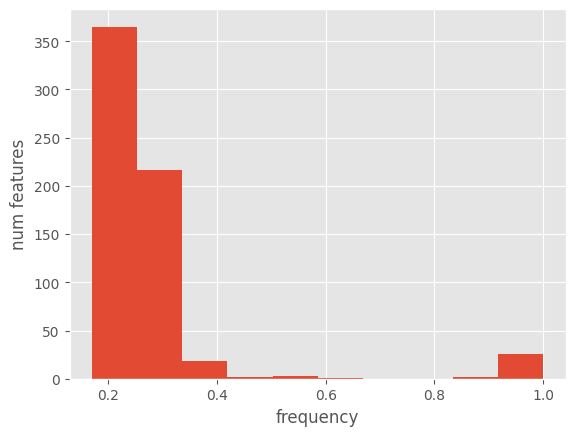

In [37]:
plt.hist(gamma_means_2)
plt.xlabel("frequency")
plt.ylabel("num features")

In [39]:
gamma_idx_2 = jnp.argwhere(gamma_means_2 > 0.3).ravel()
print(len(gamma_idx_2))
gamma_idx_2

85


DeviceArray([  1,   5,   7,  23,  28,  57,  60,  65,  67,  79,  87,  95,
             110, 133, 143, 176, 183, 189, 201, 214, 218, 223, 235, 242,
             257, 260, 271, 298, 306, 312, 317, 319, 322, 325, 335, 348,
             351, 355, 360, 391, 393, 395, 397, 407, 424, 439, 448, 457,
             460, 467, 469, 479, 483, 485, 486, 495, 498, 501, 505, 514,
             516, 518, 534, 535, 539, 555, 562, 565, 575, 581, 582, 585,
             586, 590, 593, 597, 599, 600, 603, 614, 619, 622, 625, 626,
             628], dtype=int32)

In [40]:
sel_entrz_id_2 = X_train_sig.iloc[:,gamma_idx_2].columns.to_list()

In [41]:
X_train_sel_2, X_test_sel_2 = X_train_df.loc[:, sel_entrz_id_2], X_test_df.loc[:, sel_entrz_id_2]
X_train_sel_2.shape

(449, 85)

In [42]:
%autoreload
from moses_estimator import *

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

moses_est_2 = MosesEstimator(seed=1234, num_models=100, num_evals=1000, prob="it")


moses_grid_cv_2 = GridSearchCV(estimator=moses_est_2, param_grid=moses_grid_params, verbose=3,
                             cv=cv, n_jobs=-1).fit(X_train_sel_2, y_train_df, output_label="posOutcome")

print(moses_grid_cv_2.best_params_)
print(moses_grid_cv_2.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 2/5] END complexity_ratio=1000.0, complexity_temp=31.622776601683793, diversity_pressure=0.3, hc_fraction_nn=0.01;, score=0.699 total time=   5.5s
[CV 3/5] END complexity_ratio=1000.0, complexity_temp=31.622776601683793, diversity_pressure=0.6, hc_fraction_nn=0.1;, score=0.720 total time=   5.3s
[CV 2/5] END complexity_ratio=1000.0, complexity_temp=100.0, diversity_pressure=0.0, hc_fraction_nn=0.1;, score=0.703 total time=   5.3s
[CV 2/5] END complexity_ratio=1000.0, complexity_temp=100.0, diversity_pressure=0.6, hc_fraction_nn=0.01;, score=0.756 total time=   5.1s
[CV 1/5] END complexity_ratio=1000.0, complexity_temp=316.22776601683796, diversity_pressure=0.0, hc_fraction_nn=0.01;, score=0.556 total time=   3.7s
[CV 4/5] END complexity_ratio=1000.0, complexity_temp=316.22776601683796, diversity_pressure=0.3, hc_fraction_nn=0.01;, score=0.784 total time=   4.3s
[CV 4/5] END complexity_ratio=1000.0, complexity_temp=316.

In [52]:
%autoreload
from moses_estimator import *
moses_best_params_2 = {'complexity_ratio': 1.0, 'complexity_temp': 1000.0, 'diversity_pressure': 0.9, 'hc_fraction_nn': 0.1}

moses_est_2 = MosesEstimator(seed=1234, num_models=100, num_evals=1000,
                           prob="it", **moses_best_params_2)
cv_score = cross_val_score(moses_est, X_train_sel_2, y_train_df, cv=cv, fit_params={"output_label": "posOutcome"}, n_jobs=-1)
print(np.mean(cv_score))
moses_est_2.fit(X_train_sel_2, y_train_df, output_label="posOutcome")
moses_est_2.score(X_test_sel_2, y_test_df)

0.7184663947163947


0.6951808892571112

In [54]:
train_eval_out_2 = moses_est._eval_models(moses_est_2.models_, assign_cols(X_train_sel_2)).T
test_eval_out_2 = moses_est._eval_models(moses_est_2.models_, assign_cols(X_test_sel_2)).T
X_train_sel_moses_2 = np.concatenate([X_train_sel_2.to_numpy(), train_eval_out_2], axis=1)
X_test_sel_moses_2 = np.concatenate([X_test_sel_2.to_numpy(), test_eval_out_2], axis=1)
X_train_sel_moses_2

array([[1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 1., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 1., 1.]])

In [ ]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel_moses, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_4 = np.mean(cross_val_score(clf, X_train_sel_moses_2, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel_moses_2, y_train)
log_test_score_4 = roc_auc_score(y_test, clf.predict_proba(X_test_sel_moses_2)[:,1])
print(f"cv score: {log_cv_score_4}, test_score: {log_test_score_4}")

In [55]:
from sklearn.linear_model import LogisticRegression

log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=3, scoring="roc_auc", cv=cv).fit(X_train_sel_moses, y_train)
print(log_grid_cv.best_params_)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
log_cv_score_4 = np.mean(cross_val_score(clf, X_train_sel_moses_2, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train_sel_moses_2, y_train)
log_test_score_4 = roc_auc_score(y_test, clf.predict_proba(X_test_sel_moses_2)[:,1])
print(f"cv score: {log_cv_score_4}, test_score: {log_test_score_4}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ............................C=0.01;, score=0.788 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.794 total time=   0.1s
[CV 3/5] END ............................C=0.01;, score=0.749 total time=   0.1s
[CV 4/5] END ............................C=0.01;, score=0.802 total time=   0.3s
[CV 5/5] END ............................C=0.01;, score=0.717 total time=   0.1s
[CV 1/5] END ............C=0.021544346900318832;, score=0.795 total time=   0.0s
[CV 2/5] END ............C=0.021544346900318832;, score=0.808 total time=   0.0s
[CV 3/5] END ............C=0.021544346900318832;, score=0.758 total time=   0.1s
[CV 4/5] END ............C=0.021544346900318832;, score=0.787 total time=   0.0s
[CV 5/5] END ............C=0.021544346900318832;, score=0.722 total time=   0.0s
[CV 1/5] END ............C=0.046415888336127774;, score=0.786 total time=   0.0s
[CV 2/5] END ............C=0.046415888336127774;

# Multiple Runs

In [13]:
exp_dir = f"{data_dir}/exp_data_4/cancer/fisher"

exp_seeds = []

with open(f"{exp_dir}/seeds_main.txt", "r") as fp:
    for s in fp.readlines():
        exp_seeds.append(int(s.strip()))

len(exp_seeds)

20

In [24]:


res_dfs = []

for seed in exp_seeds:

    res_df = pd.read_csv(f"{exp_dir}/res_summary_cosmic_genes_s_{seed}.csv")
    res_dfs.append(res_df)

exp_res_df = pd.concat(res_dfs, axis=0)
exp_res_df

,seed,classifier,num_feats,cv_score,test_score
0,422,LR,685,0.852667,0.745374
1,422,SVM,685,0.857564,0.727285
2,422,BNN,685,0.848506,0.723833
3,422,BNN + LR,70,0.856729,0.685446
0,261,LR,588,0.839079,0.738608
...,...,...,...,...,...
3,226,BNN + LR,70,0.786987,0.699530
0,196,LR,668,0.861758,0.717481
1,196,SVM,668,0.869464,0.722314
2,196,BNN,668,0.865420,0.706987


In [130]:
exp_res_df.iloc[-13:]

,seed,classifier,num_feats,cv_score,test_score
3,769,BNN + LR,70,0.881317,0.715410
0,920,LR,544,0.870903,0.726319
1,920,SVM,544,0.875068,0.726595
2,920,BNN,544,0.864365,0.730875
3,920,BNN + LR,70,0.850037,0.728252
0,226,LR,730,0.814266,0.716515
1,226,SVM,730,0.821253,0.715272
2,226,BNN,730,0.815274,0.724800
3,226,BNN + LR,70,0.786987,0.699530
0,196,LR,668,0.861758,0.717481


In [22]:
clf_mean_scs = exp_res_df.groupby("classifier")[["cv_score", "test_score"]].mean()
clf_mean_scs

,cv_score,test_score
classifier,,
BNN,0.846156,0.725090
BNN + LR,0.848731,0.702382
LR,0.846099,0.728128
SVM,0.854914,0.730451


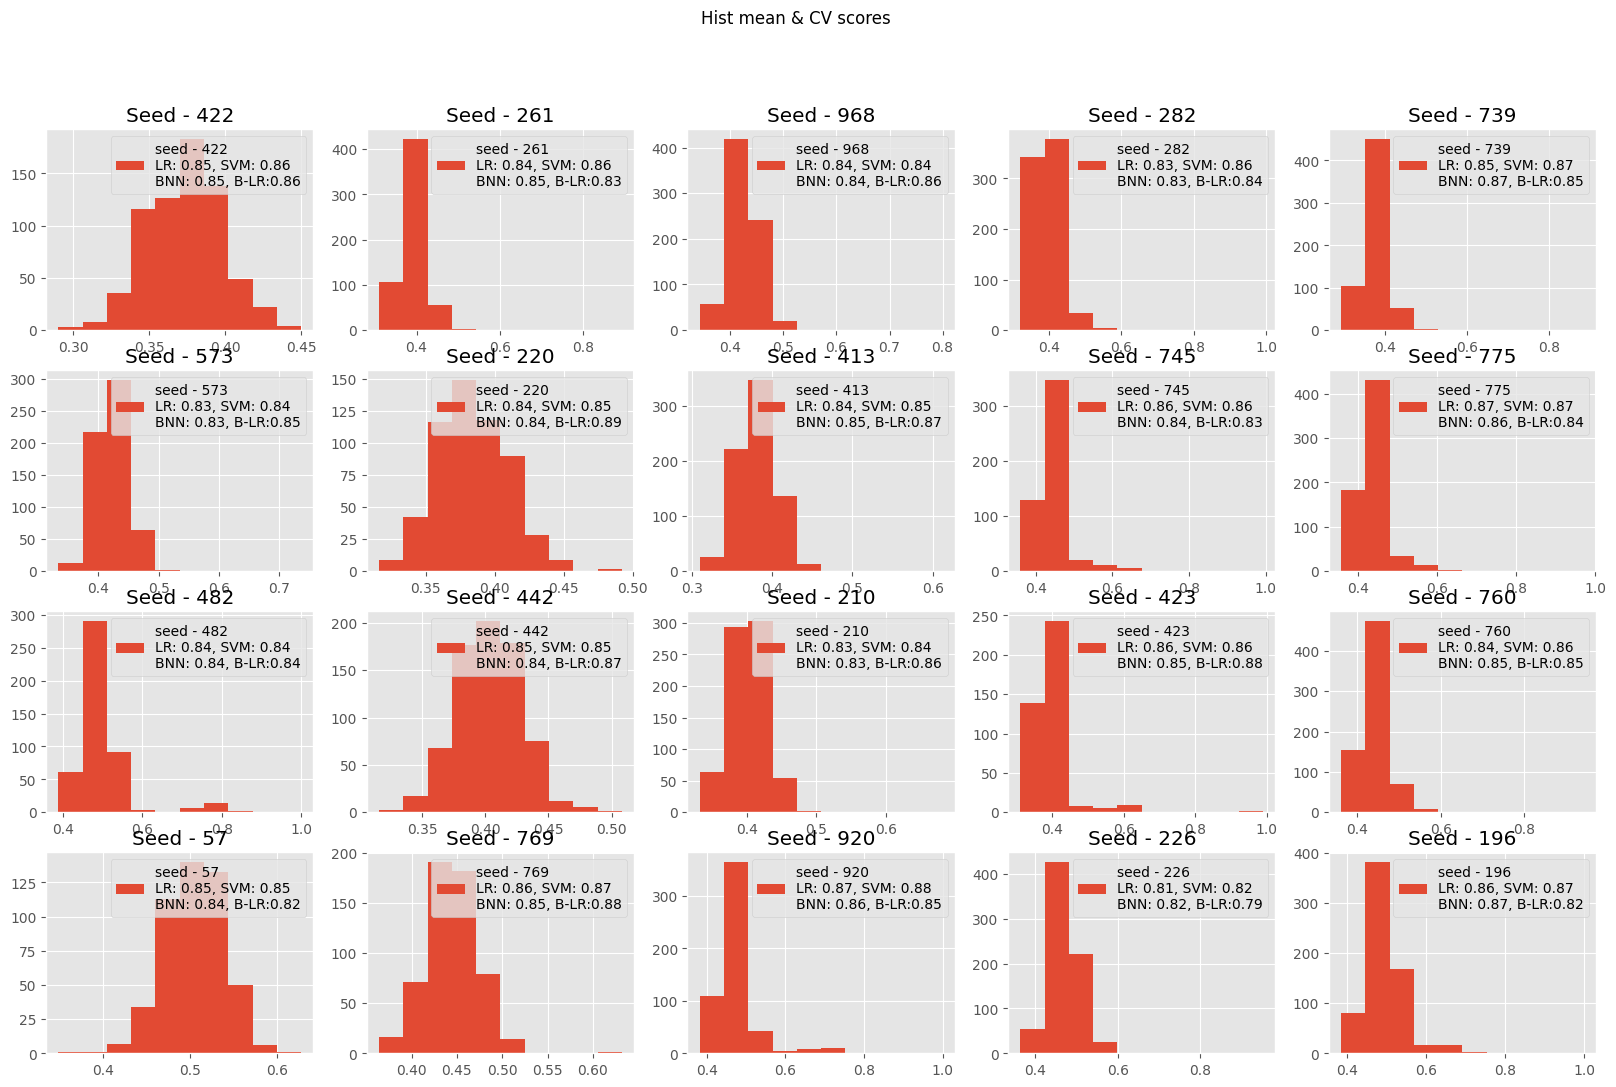

In [12]:
import glob
bnn_disc_means = []

for seed in exp_seeds:
    disc_mean = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    bnn_disc_means.append(disc_mean)


nrows = 4
ncols = 5
fig, axs = plt.subplots(4, 5, figsize=(20, 12))
fig.suptitle("Hist mean & CV scores")
k = 0
for i in range(nrows):
    for j in range(ncols):
        seed = exp_seeds[k]
        scores = exp_res_df[exp_res_df["seed"] == seed]["cv_score"].to_list()
        axs[i, j].hist(bnn_disc_means[k], label=f"seed - {seed}\nLR: {scores[0]:.2f}, SVM: {scores[1]:.2f}\nBNN: {scores[2]:.2f}, B-LR:{scores[3]:.2f}")
        k += 1
        axs[i, j].set_title(f"Seed - {seed}")
        axs[i, j].legend()

In [18]:
bnn_lr_quantile = {"seed": [], "cv_score": [], "test_score": [], "feat_len": [], "75%": []}

for seed in exp_seeds:
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means_s = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_quantile = np.quantile(gamma_means_s, [0., 0.25, 0.5, 0.75, 1.])
    gamma_mean_75 = gamma_means_quantile[3]
    gamma_idx = np.argwhere(gamma_means_s > gamma_mean_75).ravel()
    # gamma_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    print(f"seed - {seed}, gamma size - {len(gamma_idx)}")

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    # print(idx_sig)
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train_sig, X_test_sig = X_train.iloc[:,idx_sig].to_numpy(), X_test.iloc[:,idx_sig].to_numpy()
    X_train_sel, X_test_sel = X_train_sig[:, gamma_idx], X_test_sig[:, gamma_idx]
    log_param_grid = {"C":np.logspace(-2, 1, 10)}
    log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=1, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train.to_numpy())
    print(log_grid_cv.best_params_)
    clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
    log_cv_score= np.mean(cross_val_score(clf, X_train_sel, y_train, scoring="roc_auc", cv=cv))
    clf.fit(X_train_sel, y_train)
    log_test_score= roc_auc_score(y_test.to_numpy(), clf.predict_proba(X_test_sel)[:,1])
    print(f"cv score: {log_cv_score}, test_score: {log_test_score}")

    bnn_lr_quantile["seed"].append(seed)
    bnn_lr_quantile["cv_score"].append(log_cv_score)
    bnn_lr_quantile["test_score"].append(log_test_score)
    bnn_lr_quantile["feat_len"].append(len(gamma_idx))
    bnn_lr_quantile["75%"].append(gamma_mean_75)

seed - 422, gamma size - 162
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.021544346900318832}
cv score: 0.8487995337995338, test_score: 0.6884838442419221
seed - 261, gamma size - 145
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.046415888336127774}
cv score: 0.8450174825174827, test_score: 0.723971278652306
seed - 968, gamma size - 185
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.046415888336127774}
cv score: 0.8757925407925409, test_score: 0.7326705330019332
seed - 282, gamma size - 187
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.021544346900318832}
cv score: 0.8537509712509713, test_score: 0.6980115990057996
seed - 739, gamma size - 147
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.021544346900318832}
cv score: 0.8742696192696192, test_score: 0.7101629384148025
seed - 573, gamma size - 137
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.04641588

In [19]:
bnn_lr_quantile_df = pd.DataFrame(bnn_lr_quantile)
bnn_lr_quantile_df[["cv_score", "test_score"]].mean()

cv_score      0.864829
test_score    0.711040
dtype: float64

### MOSES

In [23]:
moses_res_dfs = []

for seed in exp_seeds:
    res_df = pd.read_csv(f"{exp_dir}/moses/res_summary_fisher_genes_moses_s_{seed}.csv")
    moses_res_dfs.append(res_df)

moses_res_df = pd.concat(moses_res_dfs, axis=0)
moses_res_df

,seed,classifier,num_feats,cv_score,test_score
0,422,BNN + MOSES,70,0.775092,0.651754
1,422,BNN + MOSES + LR,70,0.859718,0.689589
0,261,BNN + MOSES,70,0.734202,0.642640
1,261,BNN + MOSES + LR,70,0.832242,0.728942
0,968,BNN + MOSES,70,0.734741,0.689450
1,968,BNN + MOSES + LR,70,0.856740,0.712925
0,282,BNN + MOSES,70,0.745235,0.644711
1,282,BNN + MOSES + LR,70,0.827230,0.680889
0,739,BNN + MOSES,70,0.712788,0.725766
1,739,BNN + MOSES + LR,70,0.857156,0.735846


In [24]:
moses_clf_mean_scs = moses_res_df.groupby("classifier")[["cv_score", "test_score"]].mean()
moses_clf_mean_scs

,cv_score,test_score
classifier,,
BNN + MOSES,0.743641,0.647086
BNN + MOSES + LR,0.848794,0.703155


In [25]:
avg_num_feats = np.mean(exp_res_df["num_feats"])
res_summary_dict = {"classifier": ["LR", "SVM", "BNN", "BNN + LR", "BNN + LR + MOSES"], "num_feats": [avg_num_feats, avg_num_feats, avg_num_feats, 70, 170],
                    "mean_cv_score": [clf_mean_scs.loc["LR"].cv_score, clf_mean_scs.loc["SVM"].cv_score, clf_mean_scs.loc["BNN"].cv_score,
                                      clf_mean_scs.loc["BNN + LR"].cv_score, moses_clf_mean_scs.loc["BNN + MOSES + LR"].cv_score], "mean_test_score":
                    [clf_mean_scs.loc["LR"].test_score, clf_mean_scs.loc["SVM"].test_score, clf_mean_scs.loc["BNN"].test_score,
                     clf_mean_scs.loc["BNN + LR"].test_score, moses_clf_mean_scs.loc["BNN + MOSES + LR"].test_score]}

res_summary_df = pd.DataFrame(res_summary_dict)
res_summary_df

,classifier,num_feats,mean_cv_score,mean_test_score
0,LR,486.1,0.846099,0.728128
1,SVM,486.1,0.854914,0.730451
2,BNN,486.1,0.846156,0.725090
3,BNN + LR,70.0,0.848731,0.702382
4,BNN + LR + MOSES,170.0,0.848794,0.703155


In [20]:
res_summary_df

NameError: name 'res_summary_df' is not defined

### Check MOSES Added Columns

In [39]:
train_evals = []
test_evals = []
for seed in exp_seeds:
    train_eval = np.load(f"{exp_dir}/moses/moses_train_eval_out_s_{seed}.npy")
    test_eval = np.load(f"{exp_dir}/moses/moses_test_eval_out_s_{seed}.npy")

    train_evals.append(train_eval)
    test_evals.append(test_eval)

In [40]:
import pickle
from tqdm import tqdm

moses_lr_eval = {"nfeats": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]
    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    params = pickle.load(open(f"{exp_dir}/bnn_lr_best_params_s_{seed}.pickle", "rb"))
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df, test_size=0.3)
    X_train_sig, X_test_sig = X_train.iloc[:, idx_sig], X_test.iloc[:,idx_sig]
    X_train_sel, X_test_sel = X_train_sig.iloc[:, sel_feat_idx].to_numpy(), X_test_sig.iloc[:, sel_feat_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    lr_clf = LogisticRegression(max_iter=10000, **params)
    cv_score = np.mean(cross_val_score(lr_clf, X_train_sel, y_train, cv=cv))
    lr_clf.fit(X_train_sel, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel)[:,1])
    Cs = {"C": np.logspace(-2, 1, 10)}

    mm_cv_scs = np.zeros(train_eval.shape[1])
    mm_test_scs = np.zeros(train_eval.shape[1])

    for i in range(train_eval.shape[1]):
        X_train_sel_moses, X_test_sel_moses = np.concatenate([X_train_sel, train_eval[:,:i]], axis=1), \
                                              np.concatenate([X_test_sel, test_eval[:,:i]], axis=1)

        lr_clf = LogisticRegression(max_iter=10000)
        grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(X_train_sel_moses, y_train)
        cv_score = grid_search_cv.best_score_
        lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
        lr_clf.fit(X_train_sel_moses, y_train)
        test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel_moses)[:,1])

        mm_cv_scs[i] = cv_score
        mm_test_scs[i] = test_score

    idx_max = np.argmax(mm_cv_scs)
    cv_score = mm_cv_scs[idx_max]
    test_score = mm_test_scs[idx_max]

    moses_lr_eval["nfeats"].append(idx_max)
    moses_lr_eval["cv_score"].append(cv_score)
    moses_lr_eval["test_score"].append(test_score)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [1:01:27<00:00, 184.40s/it]


In [80]:
moses_lr_eval_df = pd.DataFrame(moses_lr_eval)
moses_lr_eval_df["seed"] = exp_seeds
moses_lr_eval_df

,nfeats,cv_score,test_score,seed
0,10,0.867906,0.703673,422
1,44,0.850501,0.732394,261
2,1,0.871191,0.711130,968
3,7,0.841253,0.686413,282
4,31,0.867407,0.735846,739
5,34,0.859765,0.715548,573
6,14,0.883151,0.709058,220
7,11,0.856944,0.675642,413
8,25,0.846527,0.670947,745
9,10,0.859839,0.705882,775


In [42]:
moses_lr_eval_df[["cv_score", "test_score"]].mean()

cv_score      0.857131
test_score    0.704343
dtype: float64

### Rank the models by logistic regression coefficient

In [44]:
moses_models_lr_eval = {"seed": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]
    _, _, y_train, y_test = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df, test_size=0.3)
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
    Cs = {"C": np.logspace(-2, 1, 10)}

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(train_eval, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(train_eval, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(test_eval)[:,1])


    moses_models_lr_eval["seed"].append(seed)
    moses_models_lr_eval["cv_score"].append(cv_score)
    moses_models_lr_eval["test_score"].append(test_score)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.79s/it]


In [45]:
moses_models_lr_eval_df = pd.DataFrame(moses_models_lr_eval)
moses_models_lr_eval_df[["cv_score", "test_score"]].mean()

cv_score      0.772114
test_score    0.653404
dtype: float64

In [56]:
moses_models_lr_ranked = {"seed": [],  "cv_score": [], "test_score": []}

for t in tqdm(range(len(exp_seeds))):
    seed = exp_seeds[t]
    train_eval = train_evals[t]
    test_eval = test_evals[t]

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df, test_size=0.3)

    X_train_sig, X_test_sig = X_train.iloc[:, idx_sig], X_test.iloc[:,idx_sig]
    X_train_sel, X_test_sel = X_train_sig.iloc[:, sel_feat_idx].to_numpy(), X_test_sig.iloc[:, sel_feat_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    Cs = {"C": np.logspace(-2, 1, 10)}

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(train_eval, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(train_eval, y_train)
    weights = lr_clf.coef_[0]
    weight_idx = np.argsort(weights)[::-1][:10]

    X_train_sel_moses, X_test_sel_moses = np.concatenate([X_train_sel, train_eval[:,weight_idx]], axis=1), \
                                          np.concatenate([X_test_sel, test_eval[:,weight_idx]], axis=1)

    lr_clf = LogisticRegression(max_iter=10000)
    grid_search_cv = GridSearchCV(lr_clf, Cs, scoring="roc_auc").fit(X_train_sel_moses, y_train)
    cv_score = grid_search_cv.best_score_
    lr_clf = LogisticRegression(max_iter=10000, **grid_search_cv.best_params_)
    lr_clf.fit(X_train_sel_moses, y_train)
    test_score = roc_auc_score(y_test, lr_clf.predict_proba(X_test_sel_moses)[:,1])


    moses_models_lr_ranked["seed"].append(seed)
    moses_models_lr_ranked["cv_score"].append(cv_score)
    moses_models_lr_ranked["test_score"].append(test_score)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.72s/it]


In [58]:
moses_models_lr_ranked_df = pd.DataFrame(moses_models_lr_ranked)
moses_models_lr_ranked_df[["cv_score", "test_score"]].mean()

cv_score      0.855945
test_score    0.705365
dtype: float64

### Check Non-linearity of selected features

In [95]:
svm_param_kernels = {"seed": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):
    svc_params = pickle.load(open(f"{exp_dir}/svm_best_params_s_{seed}.pickle", "rb"))
    svm_res = exp_res_df[(exp_res_df["seed"] == seed) &
                                 (exp_res_df["classifier"] == "SVM")]
    svc_cv_score = svm_res["cv_score"].iloc[0]
    svc_test_score = svm_res["test_score"].iloc[0]

    svm_param_kernels["seed"].append(seed)
    svm_param_kernels["cv_score"].append(svc_cv_score)
    svm_param_kernels["test_score"].append(svc_test_score)
    svm_param_kernels["kernel"].append(svc_params["kernel"])


svm_param_kernels_df = pd.DataFrame(svm_param_kernels)
svm_param_kernels_df

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1944.37it/s]


,seed,cv_score,test_score,kernel
0,422,0.857564,0.727285,poly
1,261,0.858495,0.747998,poly
2,968,0.844239,0.747238,poly
3,282,0.855392,0.716239,rbf
4,739,0.867636,0.721624,rbf
5,573,0.843631,0.747722,poly
6,220,0.845103,0.729771,poly
7,413,0.846931,0.710715,rbf
8,745,0.862978,0.731290,rbf
9,775,0.871197,0.679923,poly


In [62]:
from sklearn.svm import SVC
bnn_sel_fts_svm = {"seed": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    sel_feat_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")
    # print(idx_sig)
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train_sig, X_test_sig = X_train.iloc[:,idx_sig].to_numpy(), X_test.iloc[:,idx_sig].to_numpy()
    X_train_sel, X_test_sel = X_train_sig[:, sel_feat_idx], X_test_sig[:, sel_feat_idx]

    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
    svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=0,
                               scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)

    svc_cv_score = svc_grid_cv.best_score_
    clf = SVC(probability=True,  **svc_grid_cv.best_params_)
    clf.fit(X_train_sel, y_train)
    svc_test_score = roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:, 1])

    bnn_sel_fts_svm["seed"].append(seed)
    bnn_sel_fts_svm["cv_score"].append(svc_cv_score)
    bnn_sel_fts_svm["test_score"].append(svc_test_score)
    bnn_sel_fts_svm["kernel"].append(svc_grid_cv.best_params_["kernel"])


bnn_sel_fts_svm_df = pd.DataFrame(bnn_sel_fts_svm)
bnn_sel_fts_svm_df

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.74s/it]


,seed,cv_score,test_score,kernel
0,422,0.854577,0.666667,linear
1,261,0.841360,0.747307,linear
2,968,0.858500,0.732532,linear
3,282,0.854664,0.694560,poly
4,739,0.852836,0.727838,rbf
5,573,0.851987,0.727561,linear
6,220,0.890592,0.717343,linear
7,413,0.866169,0.704294,linear
8,745,0.843594,0.657829,rbf
9,775,0.843502,0.727423,linear


In [64]:
bnn_sel_fts_svm_df[["cv_score", "test_score"]].mean()

cv_score      0.850810
test_score    0.708703
dtype: float64

In [15]:
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.svm import SVC

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_svm_dict = {"seed": [], "num_feats": [], "cv_score": [], "test_score": [], "kernel": []}

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    X_train, X_test = X_train.iloc[:,idx_sig].to_numpy(), X_test.iloc[:,idx_sig].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    cv_score_max = 0.0
    flen_max = 0.0
    param_flen_max = None

    svc_param_grid = {"C": np.logspace(-2, 1, 10), "kernel": ["rbf", "linear", "poly"], "degree": [2, 3]}
    for feat_len in feat_lens:
        gamma_idx = gamma_means_idx_s[:feat_len]
        X_train_sel, X_test_sel = X_train[:,gamma_idx], X_test[:,gamma_idx]
        svc_grid_cv = GridSearchCV(estimator=SVC(probability=True), param_grid=svc_param_grid, verbose=0,
                                   scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)

        cv_score = svc_grid_cv.best_score_
        if cv_score > cv_score_max:
            cv_score_max = cv_score
            flen_max = feat_len
            param_flen_max = svc_grid_cv.best_params_

    gamma_idx = gamma_means_idx_s[:flen_max]
    X_train_sel, X_test_sel = X_train[:, gamma_idx], X_test[:, gamma_idx]
    svc_clf = SVC(probability=True, **param_flen_max)
    svc_clf.fit(X_train_sel, y_train)
    test_score = roc_auc_score(y_test, svc_clf.predict_proba(X_test_sel)[:, 1])
    # print(f"seed: {seed}, Optim feat len: {flen_max}, cv_score: {cv_score_max}, test_score: {test_score}")

    bnn_feat_len_svm_dict["seed"].append(seed)
    bnn_feat_len_svm_dict["num_feats"].append(flen_max)
    bnn_feat_len_svm_dict["cv_score"].append(cv_score_max)
    bnn_feat_len_svm_dict["test_score"].append(test_score)
    bnn_feat_len_svm_dict["kernel"].append(param_flen_max["kernel"])

bnn_feat_len_svm_df = pd.DataFrame(bnn_feat_len_svm_dict)


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [21:41<00:00, 65.06s/it]


,seed,num_feats,cv_score,test_score,kernel
0,422,40,0.859406,0.664319,linear
1,261,90,0.864435,0.722798,poly
2,968,100,0.863681,0.730461,linear
3,282,80,0.860921,0.707954,poly
4,739,100,0.869580,0.719415,rbf
5,573,90,0.874854,0.744684,linear
6,220,80,0.895981,0.724386,rbf
7,413,60,0.870705,0.696769,linear
8,745,100,0.863761,0.648854,rbf
9,775,100,0.870559,0.678542,rbf


In [8]:
# bnn_feat_len_svm_df.to_csv(f"{exp_dir}/moses/bnn_fisher_feat_len_svm.csv")
bnn_feat_len_svm_df = pd.read_csv(f"{exp_dir}/moses/bnn_fisher_feat_len_svm.csv")

In [9]:
bnn_feat_len_svm_df[["num_feats", "cv_score", "test_score"]].mean()

num_feats     87.000000
cv_score       0.864937
test_score     0.706190
dtype: float64

In [11]:
bnn_feat_len_svm_df["kernel"].value_counts()

linear    10
rbf        6
poly       4
Name: kernel, dtype: int64

In [ ]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_moses_dict = {"seed": [], "classifier": [] ,"num_feats": [], "cv_score": [], "test_score": [],
                           "kernel": []}

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
    X_train, X_test = X_train.iloc[:,idx_sig], X_test.iloc[:,idx_sig]
    feat_len = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["num_feats"].iloc[0]
    kernel = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["kernel"].iloc[0]
    gamma_idx = gamma_means_idx_s[:feat_len]
    X_train_sel, X_test_sel = X_train.iloc[:,gamma_idx], X_test.iloc[:,gamma_idx]

    _, moses_cv_score, moses_test_score, \
    train_eval_out, test_eval_out = run_moses(seed, X_train_sel, X_test_sel, y_train, y_test, "posOutcome", cv)

    X_train_sel_moses = np.concatenate([X_train_sel.to_numpy(), train_eval_out], axis=1)
    X_test_sel_moses = np.concatenate([X_test_sel.to_numpy(), test_eval_out], axis=1)

    _, log_cv_score, log_test_score = run_logistc_regression(X_train_sel_moses, X_test_sel_moses,
                                                             y_train, y_test, cv)

    bnn_feat_len_moses_dict["classifier"].append("MOSES")
    bnn_feat_len_moses_dict["seed"].append(seed)
    bnn_feat_len_moses_dict["num_feats"].append(feat_len)
    bnn_feat_len_moses_dict["cv_score"].append(moses_cv_score)
    bnn_feat_len_moses_dict["test_score"].append(moses_test_score)
    bnn_feat_len_moses_dict["kernel"].append(kernel)

    bnn_feat_len_moses_dict["classifier"].append("MOSES + LR")
    bnn_feat_len_moses_dict["seed"].append(seed)
    bnn_feat_len_moses_dict["num_feats"].append(feat_len + train_eval_out.shape[1])
    bnn_feat_len_moses_dict["cv_score"].append(log_cv_score)
    bnn_feat_len_moses_dict["test_score"].append(log_test_score)
    bnn_feat_len_moses_dict["kernel"].append(kernel)

bnn_feat_len_moses_df = pd.DataFrame(bnn_feat_len_moses_dict)
bnn_feat_len_moses_df

In [101]:
bnn_feat_len_moses_df[bnn_feat_len_moses_df["classifier"] == "MOSES + LR"][["cv_score", "test_score"]].mean()

cv_score      0.858965
test_score    0.701588
dtype: float64

In [ ]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression

feat_lens = np.arange(10, 110, 10)

bnn_feat_len_lr_dict = {"seed": [], "classifier": [] ,"num_feats": [], "cv_score": [], "test_score": [],
                           "kernel": []}

moses_grid_params = {"complexity_ratio": np.logspace(0, 3, 5), "complexity_temp": np.logspace(1, 3, 5),
                     "diversity_pressure": [0.0, 0.3, 0.6, 0.9], "hc_fraction_nn": [0.01, 0.1],
                     }

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()
    X_train, X_test = X_train.iloc[:,idx_sig], X_test.iloc[:,idx_sig]
    feat_len = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["num_feats"].iloc[0]
    kernel = bnn_feat_len_svm_df[bnn_sel_fts_svm_df["seed"] == seed]["kernel"].iloc[0]
    gamma_idx = gamma_means_idx_s[:feat_len]
    X_train_sel, X_test_sel = X_train.iloc[:,gamma_idx], X_test.iloc[:,gamma_idx]

    _, log_cv_score, log_test_score = run_logistc_regression(X_train_sel, X_test_sel, y_train, y_test, cv)


    bnn_feat_len_lr_dict["classifier"].append("LR")
    bnn_feat_len_lr_dict["seed"].append(seed)
    bnn_feat_len_lr_dict["num_feats"].append(feat_len)
    bnn_feat_len_lr_dict["cv_score"].append(log_cv_score)
    bnn_feat_len_lr_dict["test_score"].append(log_test_score)
    bnn_feat_len_lr_dict["kernel"].append(kernel)


bnn_feat_len_lr_df = pd.DataFrame(bnn_feat_len_lr_dict)
bnn_feat_len_lr_df

In [106]:
bnn_feat_len_lr_df[["cv_score", "test_score"]].mean()

cv_score      0.861277
test_score    0.704053
dtype: float64

### Randomly selected vs BNN selected

In [45]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression
from tqdm import tqdm

rand_v_bnn_sel_fts_dict_1 = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

feat_lens = [5, 10]

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    all_feats = np.arange(X_train.shape[1])
    all_fisher = np.arange(len(idx_sig))

    X_train_sig, X_test_sig = X_train[:,idx_sig], X_test[:,idx_sig]

    rng_key = jax.random.PRNGKey(seed)

    for ft_len in feat_lens:
        rand_sel_all_fts = jax.random.choice(rng_key, all_feats, (ft_len,), replace=False)
        rand_sel_fisher_fts = jax.random.choice(rng_key, all_fisher, (ft_len,), replace=False)

        X_train_rand_all_sel, X_test_rand_all_sel = X_train[:,rand_sel_all_fts], X_test[:,rand_sel_all_fts]
        X_train_rand_fisher_sel, X_test_rand_fisher_sel = X_train_sig[:,rand_sel_fisher_fts], X_test_sig[:,rand_sel_fisher_fts]


        _, rand_all_cv_score, rand_all_test_score = run_logistc_regression(X_train_rand_all_sel, X_test_rand_all_sel,
                                                                   y_train, y_test, cv, verbose=0)

        _, rand_fisher_cv_score, rand_fisher_test_score = run_logistc_regression(X_train_rand_fisher_sel, X_test_rand_fisher_sel,
                                                                                 y_train, y_test, cv, verbose=0)

        sel_fts = gamma_means_idx_s[:ft_len]

        X_train_sel, X_test_sel = X_train_sig[:,sel_fts], X_test_sig[:,sel_fts]

        _, cv_score, test_score = run_logistc_regression(X_train_sel, X_test_sel,
                                                         y_train, y_test, cv, verbose=0)

        rand_v_bnn_sel_fts_dict_1["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_1["feat_sel"].append("random_all")
        rand_v_bnn_sel_fts_dict_1["num_feats"].append(rand_sel_all_fts.size)
        rand_v_bnn_sel_fts_dict_1["cv_score"].append(rand_all_cv_score)
        rand_v_bnn_sel_fts_dict_1["test_score"].append(rand_all_test_score)

        rand_v_bnn_sel_fts_dict_1["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_1["feat_sel"].append("random_fisher")
        rand_v_bnn_sel_fts_dict_1["num_feats"].append(rand_sel_fisher_fts.size)
        rand_v_bnn_sel_fts_dict_1["cv_score"].append(rand_fisher_cv_score)
        rand_v_bnn_sel_fts_dict_1["test_score"].append(rand_fisher_test_score)

        rand_v_bnn_sel_fts_dict_1["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_1["feat_sel"].append("bnn")
        rand_v_bnn_sel_fts_dict_1["num_feats"].append(sel_fts.size)
        rand_v_bnn_sel_fts_dict_1["cv_score"].append(cv_score)
        rand_v_bnn_sel_fts_dict_1["test_score"].append(test_score)


rand_v_bnn_sel_fts_df_1 = pd.DataFrame(rand_v_bnn_sel_fts_dict_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.12it/s]


In [46]:
rand_v_bnn_sel_fts_df_1.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel      num_feats                      
bnn           5          0.681760    0.607256
              10         0.733988    0.627589
random_all    5          0.538098    0.552075
              10         0.572175    0.569200
random_fisher 5          0.674848    0.608896
              10         0.713215    0.626667

In [59]:
from scipy import stats
bnn_sel_ft_5 = rand_v_bnn_sel_fts_df_1[(rand_v_bnn_sel_fts_df_1["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_1["num_feats"] == 5)]
rand_fisher_sel_ft_5 = rand_v_bnn_sel_fts_df_1[(rand_v_bnn_sel_fts_df_1["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_1["num_feats"] == 5)]

bnn_sel_ft_10 = rand_v_bnn_sel_fts_df_1[(rand_v_bnn_sel_fts_df_1["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_1["num_feats"] == 10)]
rand_fisher_sel_ft_10 = rand_v_bnn_sel_fts_df_1[(rand_v_bnn_sel_fts_df_1["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_1["num_feats"] == 10)]

cv_score_bnn_sel_ft_5 = bnn_sel_ft_5["cv_score"]
cv_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["cv_score"]

cv_score_bnn_sel_ft_10 = bnn_sel_ft_10["cv_score"]
cv_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["cv_score"]

test_score_bnn_sel_ft_5 = bnn_sel_ft_5["test_score"]
test_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["test_score"]

test_score_bnn_sel_ft_10 = bnn_sel_ft_10["test_score"]
test_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["test_score"]

p_val_cv_score_5 = stats.ttest_ind(cv_score_bnn_sel_ft_5, cv_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_5 = stats.ttest_ind(test_score_bnn_sel_ft_5, test_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue

p_val_cv_score_10 = stats.ttest_ind(cv_score_bnn_sel_ft_10, cv_score_rand_sel_ft_10, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_10 = stats.ttest_ind(test_score_bnn_sel_ft_10, test_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue

print("=========== Num feats: 5 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_5}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_5}")

print("\n=========== Num feats: 10 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_10}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_10}")

=========== Num feats: 5 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.34674109610375203
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.9112169876163632

=========== Num feats: 10 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.005790657614269137
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.26792553798268637


In [51]:
stats.ttest_rel(cv_score_bnn_sel_ft_10, cv_score_rand_sel_ft_10, alternative="greater").pvalue

0.004821327657440924

In [8]:
exp_dir = f"{data_dir}/exp_data_4/cancer/fisher"

exp_seeds = []

with open(f"{exp_dir}/seeds_main.txt", "r") as fp:
    for s in fp.readlines():
        exp_seeds.append(int(s.strip()))

len(exp_seeds)

20

In [9]:
save_dir = f"{data_dir}/exp_data_4/cancer/fisher_2"

In [19]:
%autoreload
import pickle
from tqdm import tqdm
import warnings
from nn_util import prepare_data
from sgmcmc import MixedSGMCMC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

log_param_grid = {"C":np.logspace(-2, 1, 10)}

config_values = []

bnn_lr_dict = {"seed": [], "classifier": [], "cv_score": [], "test_score": []}


for seed in exp_seeds:

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    print(f"Running - seed {seed}")
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, stratify=y_df, random_state=seed, shuffle=True)

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")

    X_train_sig, X_test_sig = X_train.iloc[:,idx_sig], X_test.iloc[:,idx_sig]
    J = build_network(X_train_sig, net_intr, net_intr_rev)
    p = J.shape[0]
    print(f"Net size: {np.count_nonzero(J) // 2}")

    rng_key = jax.random.PRNGKey(seed)

    X_train, X_test, y_train, y_test = jax.device_put(X_train_sig.to_numpy()), jax.device_put(X_test_sig.to_numpy()), \
                                       jax.device_put(y_train.to_numpy()), jax.device_put(y_test.to_numpy())


    config, bnn_cv_score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=200)

    # config = pickle.load(open(f"{save_dir}/bnn_params_s_{seed}.pickle", "rb"))
    config_values.append(config)

    pickle.dump(config, open(f"{save_dir}/bnn_params_s_{seed}.pickle", "wb"))

    params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
              "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
              "sigma": config["sigma"], "cycle_len": config["cycle_len"], "beta": config["beta"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_warmup=0,
                               n_chains=1, layer_dims=[config["layer_dim"]], **params)

    # bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv,
    #                                        fit_params={"activation_fns": [config["activation"]],  "J": net}))

    mixed_sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=J)

    bnn_test_score = mixed_sgmcmc.score(X_test, y_test)

    bnn_disc_mean = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
    np.save(f"{save_dir}/bnn_disc_mean_s_{seed}.npy", bnn_disc_mean)

    gamma_idx = jnp.argsort(bnn_disc_mean)[::-1][:100]

    X_train_sel, X_test_sel = X_train[:,gamma_idx], X_test[:,gamma_idx]

    log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=0, scoring="roc_auc", cv=cv).fit(X_train_sel, y_train)
    log_cv_score = log_grid_cv.best_score_
    clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
    clf.fit(X_train_sel, y_train)
    log_test_score = roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:,1])


    bnn_lr_dict["seed"].append(seed)
    bnn_lr_dict["classifier"].append("BNN")
    bnn_lr_dict["cv_score"].append(bnn_cv_score)
    bnn_lr_dict["test_score"].append(bnn_test_score)

    bnn_lr_dict["seed"].append(seed)
    bnn_lr_dict["classifier"].append("BNN + LR")
    bnn_lr_dict["cv_score"].append(log_cv_score)
    bnn_lr_dict["test_score"].append(log_test_score)

    print(f"Config: {config}")
    print(f"Done - seed {seed}")
    print(f"BNN cv_score: {bnn_cv_score}, BNN test_score: {bnn_test_score}")
    print(f"LR cv_score: {log_cv_score}, LR test_score: {log_test_score}")

bnn_lr_df = pd.DataFrame(bnn_lr_dict)

Running - seed 422
Net size: 33
Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 32,
  'beta': 0.8121857084304283,
  'contin_lr': 1.4906372095752082e-05,
  'cycle_len': 5,
  'disc_lr': 0.0898657014349916,
  'eta': 6.511070510261156,
  'layer_dim': 600,
  'mu': 0.024350356937991043,
  'sigma': 3.1716737507935964,
  'temp': 0.017185723039945467,
})

Done - seed 422
BNN cv_score: 0.8305030786443985, BNN test_score: 0.7299088426399818
LR cv_score: 0.7999242424242424, LR test_score: 0.7329466799870779
Running - seed 261
Net size: 30
Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 128,
  'beta': 0.3966446249283889,
  'contin_lr': 0.0001668657304515992,
  'cycle_len': 5,
  'disc_lr': 0.1600897339578054,
  'eta': 7.507710251142145,
  'layer_dim': 500,
  'mu': 0.0010687334579485425,
  'sigma': 6.713000981306499,
  'temp': 0.132022010218434,
})

Done - seed 261
BNN cv_score: 0.8364762761700384, BNN test_score: 0.7397127648228047
LR cv_score: 0.8314335

In [20]:
bnn_lr_df.to_csv(f"{save_dir}/res_bmm_summary.csv", index=False)

In [21]:
bnn_lr_df

,seed,classifier,cv_score,test_score
0,422,BNN,0.830503,0.729909
1,422,BNN + LR,0.799924,0.732947
2,261,BNN,0.836476,0.739713
3,261,BNN + LR,0.831434,0.737227
4,968,BNN,0.834617,0.693593
5,968,BNN + LR,0.846669,0.635736
6,282,BNN,0.830542,0.684479
7,282,BNN + LR,0.797642,0.670257
8,739,BNN,0.837280,0.715548
9,739,BNN + LR,0.817986,0.717067


In [22]:
bnn_lr_df.groupby(["classifier"])[["cv_score", "test_score"]].mean()

,cv_score,test_score
classifier,,
BNN,0.834910,0.720188
BNN + LR,0.831764,0.703038


In [72]:
%autoreload
from run_moses_cosmic_exp import run_moses, run_logistc_regression
from tqdm import tqdm

rand_v_bnn_sel_fts_dict_2 = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

feat_lens = [5, 10, 15, 20]

exp_dir_2 = f"{data_dir}/exp_data_4/cancer/fisher_2"

for seed in tqdm(exp_seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir_2}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]

    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    all_feats = np.arange(X_train.shape[1])
    all_fisher = np.arange(len(idx_sig))

    X_train_sig, X_test_sig = X_train[:,idx_sig], X_test[:,idx_sig]

    rng_key = jax.random.PRNGKey(seed)

    for ft_len in feat_lens:
        rand_sel_all_fts = jax.random.choice(rng_key, all_feats, (ft_len,), replace=False)
        rand_sel_fisher_fts = jax.random.choice(rng_key, all_fisher, (ft_len,), replace=False)

        X_train_rand_all_sel, X_test_rand_all_sel = X_train[:,rand_sel_all_fts], X_test[:,rand_sel_all_fts]
        X_train_rand_fisher_sel, X_test_rand_fisher_sel = X_train_sig[:,rand_sel_fisher_fts], X_test_sig[:,rand_sel_fisher_fts]


        _, rand_all_cv_score, rand_all_test_score = run_logistc_regression(X_train_rand_all_sel, X_test_rand_all_sel,
                                                                           y_train, y_test, cv, verbose=0)

        _, rand_fisher_cv_score, rand_fisher_test_score = run_logistc_regression(X_train_rand_fisher_sel, X_test_rand_fisher_sel,
                                                                                 y_train, y_test, cv, verbose=0)

        sel_fts = gamma_means_idx_s[:ft_len]

        X_train_sel, X_test_sel = X_train_sig[:,sel_fts], X_test_sig[:,sel_fts]

        _, cv_score, test_score = run_logistc_regression(X_train_sel, X_test_sel,
                                                         y_train, y_test, cv, verbose=0)

        rand_v_bnn_sel_fts_dict_2["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_2["feat_sel"].append("random_all")
        rand_v_bnn_sel_fts_dict_2["num_feats"].append(rand_sel_all_fts.size)
        rand_v_bnn_sel_fts_dict_2["cv_score"].append(rand_all_cv_score)
        rand_v_bnn_sel_fts_dict_2["test_score"].append(rand_all_test_score)

        rand_v_bnn_sel_fts_dict_2["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_2["feat_sel"].append("random_fisher")
        rand_v_bnn_sel_fts_dict_2["num_feats"].append(rand_sel_fisher_fts.size)
        rand_v_bnn_sel_fts_dict_2["cv_score"].append(rand_fisher_cv_score)
        rand_v_bnn_sel_fts_dict_2["test_score"].append(rand_fisher_test_score)

        rand_v_bnn_sel_fts_dict_2["seed"].append(seed)
        rand_v_bnn_sel_fts_dict_2["feat_sel"].append("bnn")
        rand_v_bnn_sel_fts_dict_2["num_feats"].append(sel_fts.size)
        rand_v_bnn_sel_fts_dict_2["cv_score"].append(cv_score)
        rand_v_bnn_sel_fts_dict_2["test_score"].append(test_score)


rand_v_bnn_sel_fts_df_2 = pd.DataFrame(rand_v_bnn_sel_fts_dict_2)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.31s/it]


In [73]:
rand_v_bnn_sel_fts_df_2.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel      num_feats                      
bnn           5          0.684990    0.594708
              10         0.730403    0.630768
              15         0.758023    0.652952
              20         0.773652    0.664671
random_all    5          0.538098    0.552075
              10         0.572175    0.569200
              15         0.587249    0.588398
              20         0.602351    0.589457
random_fisher 5          0.674848    0.608896
              10         0.713215    0.626667
              15         0.740995    0.649310
              20         0.754740    0.661844

In [64]:
from scipy import stats
bnn_sel_ft_5 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_2["num_feats"] == 5)]
rand_fisher_sel_ft_5 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_2["num_feats"] == 5)]

bnn_sel_ft_10 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_2["num_feats"] == 10)]
rand_fisher_sel_ft_10 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_2["num_feats"] == 10)]

cv_score_bnn_sel_ft_5 = bnn_sel_ft_5["cv_score"]
cv_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["cv_score"]

cv_score_bnn_sel_ft_10 = bnn_sel_ft_10["cv_score"]
cv_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["cv_score"]

test_score_bnn_sel_ft_5 = bnn_sel_ft_5["test_score"]
test_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["test_score"]

test_score_bnn_sel_ft_10 = bnn_sel_ft_10["test_score"]
test_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["test_score"]

p_val_cv_score_5 = stats.ttest_ind(cv_score_bnn_sel_ft_5, cv_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_5 = stats.ttest_ind(test_score_bnn_sel_ft_5, test_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue

p_val_cv_score_10 = stats.ttest_ind(cv_score_bnn_sel_ft_10, cv_score_rand_sel_ft_10, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_10 = stats.ttest_ind(test_score_bnn_sel_ft_10, test_score_rand_sel_ft_10, alternative="two-sided", equal_var=False).pvalue

print("=========== Num feats: 5 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_5}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_5}")

print("\n=========== Num feats: 10 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_10}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_10}")

=========== Num feats: 5 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.21917545802913352
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.3081350908250306

=========== Num feats: 10 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.015031062159747493
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.770384358946903


In [66]:
stats.ttest_ind(test_score_bnn_sel_ft_10, test_score_rand_sel_ft_10, alternative="greater", equal_var=False).pvalue

0.3851921794734515

In [74]:
bnn_sel_ft_15 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_2["num_feats"] == 15)]
rand_fisher_sel_ft_15 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_2["num_feats"] == 15)]

cv_score_bnn_sel_ft_15 = bnn_sel_ft_15["cv_score"]
cv_score_rand_sel_ft_15 = rand_fisher_sel_ft_15["cv_score"]

test_score_bnn_sel_ft_15 = bnn_sel_ft_15["test_score"]
test_score_rand_sel_ft_15 = rand_fisher_sel_ft_15["test_score"]

p_val_cv_score_15 = stats.ttest_ind(cv_score_bnn_sel_ft_15, cv_score_rand_sel_ft_15, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_15 = stats.ttest_ind(test_score_bnn_sel_ft_15, test_score_rand_sel_ft_15, alternative="two-sided", equal_var=False).pvalue

print("\n=========== Num feats: 15 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_15}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_15}")


=========== Num feats: 15 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.02370100809299222
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.7875495828021878


In [75]:
bnn_sel_ft_20 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df_2["num_feats"] == 20)]
rand_fisher_sel_ft_20 = rand_v_bnn_sel_fts_df_2[(rand_v_bnn_sel_fts_df_2["feat_sel"] == "random_fisher") & (rand_v_bnn_sel_fts_df_2["num_feats"] == 20)]

cv_score_bnn_sel_ft_20 = bnn_sel_ft_20["cv_score"]
cv_score_rand_sel_ft_20 = rand_fisher_sel_ft_20["cv_score"]

test_score_bnn_sel_ft_20 = bnn_sel_ft_20["test_score"]
test_score_rand_sel_ft_20 = rand_fisher_sel_ft_20["test_score"]

p_val_cv_score_20 = stats.ttest_ind(cv_score_bnn_sel_ft_20, cv_score_rand_sel_ft_20, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_20 = stats.ttest_ind(test_score_bnn_sel_ft_20, test_score_rand_sel_ft_20, alternative="two-sided", equal_var=False).pvalue

print("\n=========== Num feats: 20 =====================")
print(f"CV Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_cv_score_20}")
print(f"Test Scores: BNN vs Random Fisher - p_value (two-sided): {p_val_test_score_20}")


=========== Num feats: 20 =====================
CV Scores: BNN vs Random Fisher - p_value (two-sided): 0.024520375625042966
Test Scores: BNN vs Random Fisher - p_value (two-sided): 0.8475311974874653


In [55]:
%autoreload
from ea_train_cosmic import run_deap, run_logistc_regression
from nn_util import setup_logger
import datetime
import warnings
import time
from tqdm import tqdm
warnings.filterwarnings("ignore")

bnn_deap_dict = {"seed": [], "classifier": [], "num_feats": [], "top_5_feats": [] ,"cv_score": [], "test_score": []}

cxpb, mutpb = 0.6, 0.2
n_gen = 1000

num_feats = 10

for seed in tqdm(exp_seeds):
    # print(f"Running seed {seed}")
    logger = setup_logger(None, seed)
    start_time = time.time()

    rng_key = jax.random.PRNGKey(seed)
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)

    idx_sig = np.load(f"{exp_dir}/fisher_idx_sig_{seed}.npy")
    gamma_means = np.load(f"{exp_dir_2}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]

    selected_idx = gamma_means_idx_s[:num_feats]

    # X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=seed, shuffle=True, stratify=y_df)
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=seed, shuffle=True,
                                                        stratify=y_df, test_size=0.3)

    X_train_sig, X_test_sig = X_train.iloc[:, idx_sig], X_test.iloc[:,idx_sig]
    X_train_sel, X_test_sel = X_train_sig.iloc[:,selected_idx].to_numpy(), X_test_sig.iloc[:,selected_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_sel, y_train, random_state=seed, shuffle=True,
                                                              stratify=y_train, test_size=0.2)


    hof, val_score, test_score, train_preds, val_preds, test_preds = run_deap(rng_key, X_train_sel, X_val_sel, X_test_sel,
                                                                              y_train, y_val, y_test, cxpb, mutpb, n_gen, logger)

    X_train_sel_ea = np.concatenate([X_train_sel, train_preds], axis=1)
    X_val_sel_ea = np.concatenate([X_val_sel, val_preds], axis=1)
    X_test_sel_ea = np.concatenate([X_test_sel, test_preds], axis=1)

    clf_log, log_best_params, log_cv_score, log_test_score = run_logistc_regression(X_train_sel_ea, X_val_sel_ea, X_test_sel_ea,
                                                                                    y_train, y_val ,y_test, cv, logger)

    # Check the top 5 feats acc. Logistic Regression classifier
    top_5_feats = ",".join([str(idx) for idx in np.argsort(np.abs(clf_log.coef_[0]))[::-1][:5]])

    bnn_deap_dict["classifier"].append("DEAP")
    bnn_deap_dict["seed"].append(seed)
    bnn_deap_dict["num_feats"].append(num_feats)
    bnn_deap_dict["cv_score"].append(val_score)
    bnn_deap_dict["test_score"].append(test_score)
    bnn_deap_dict["top_5_feats"].append("-")

    bnn_deap_dict["classifier"].append("DEAP + LR")
    bnn_deap_dict["seed"].append(seed)
    bnn_deap_dict["num_feats"].append(num_feats + len(hof))
    bnn_deap_dict["cv_score"].append(log_cv_score)
    bnn_deap_dict["test_score"].append(log_test_score)
    bnn_deap_dict["top_5_feats"].append(top_5_feats)

    end_time = time.time()

    elapsed = datetime.timedelta(seconds=(end_time - start_time))
    # logger.info(f"Done for seed {seed}. Time elapsed - {elapsed}")

bnn_deap_df = pd.DataFrame(bnn_deap_dict)
bnn_deap_df

  0%|                                                                                            | 0/20 [00:00<?, ?it/s]

2022-11-01 15:24:08,424 [INFO], Num models: 5, EA Validation Score: 0.5896464646464646, Test Score: 0.6543772438552886
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:24:08,576 [INFO], LR best params {'C': 1.0}
2022-11-01 15:24:08,580 [INFO], LR scores - cv score:  0.6654, test_score:  0.7120


  5%|████▏                                                                              | 1/20 [02:17<43:26, 137.17s/it]

2022-11-01 15:25:51,223 [INFO], Num models: 5, EA Validation Score: 0.5868055555555556, Test Score: 0.6040458436895885
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:25:51,383 [INFO], LR best params {'C': 0.21544346900318834}
2022-11-01 15:25:51,386 [INFO], LR scores - cv score:  0.6875, test_score:  0.6402


 10%|████████▎                                                                          | 2/20 [03:59<35:05, 116.95s/it]

2022-11-01 15:38:43,732 [INFO], Num models: 4, EA Validation Score: 0.632260101010101, Test Score: 0.5647611157138912
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:38:43,873 [INFO], LR best params {'C': 0.21544346900318834}
2022-11-01 15:38:43,876 [INFO], LR scores - cv score:  0.7847, test_score:  0.6710


 15%|████████████▏                                                                    | 3/20 [16:52<1:57:56, 416.29s/it]

2022-11-01 15:39:56,166 [INFO], Num models: 4, EA Validation Score: 0.6054292929292928, Test Score: 0.5634493233913282
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:39:56,311 [INFO], LR best params {'C': 0.046415888336127774}
2022-11-01 15:39:56,314 [INFO], LR scores - cv score:  0.6938, test_score:  0.6384


 20%|████████████████▏                                                                | 4/20 [18:04<1:14:48, 280.54s/it]

2022-11-01 15:42:10,909 [INFO], Num models: 6, EA Validation Score: 0.5965909090909091, Test Score: 0.5398370615851975
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:42:11,063 [INFO], LR best params {'C': 0.01}
2022-11-01 15:42:11,066 [INFO], LR scores - cv score:  0.6667, test_score:  0.5616


 25%|████████████████████▊                                                              | 5/20 [20:19<56:59, 227.97s/it]

2022-11-01 15:47:18,723 [INFO], Num models: 5, EA Validation Score: 0.6613005050505051, Test Score: 0.5625517812758907
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:47:18,863 [INFO], LR best params {'C': 0.021544346900318832}
2022-11-01 15:47:18,866 [INFO], LR scores - cv score:  0.7500, test_score:  0.6459


 30%|████████████████████████▉                                                          | 6/20 [25:27<59:31, 255.11s/it]

2022-11-01 15:48:54,038 [INFO], Num models: 3, EA Validation Score: 0.6638257575757576, Test Score: 0.6286246893123447
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:48:54,167 [INFO], LR best params {'C': 0.046415888336127774}
2022-11-01 15:48:54,170 [INFO], LR scores - cv score:  0.7159, test_score:  0.6702


 35%|█████████████████████████████                                                      | 7/20 [27:02<43:57, 202.87s/it]

2022-11-01 15:50:02,613 [INFO], Num models: 6, EA Validation Score: 0.6107954545454545, Test Score: 0.6073598453465893
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:50:02,760 [INFO], LR best params {'C': 0.01}
2022-11-01 15:50:02,763 [INFO], LR scores - cv score:  0.6903, test_score:  0.6353


 40%|█████████████████████████████████▏                                                 | 8/20 [28:11<32:01, 160.12s/it]

2022-11-01 15:51:06,701 [INFO], Num models: 5, EA Validation Score: 0.6818181818181818, Test Score: 0.530447390223695
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:51:06,857 [INFO], LR best params {'C': 0.1}
2022-11-01 15:51:06,861 [INFO], LR scores - cv score:  0.7266, test_score:  0.5790


 45%|█████████████████████████████████████▎                                             | 9/20 [29:15<23:51, 130.10s/it]

2022-11-01 15:52:07,667 [INFO], Num models: 6, EA Validation Score: 0.5508207070707071, Test Score: 0.5367301850317592
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 15:52:07,816 [INFO], LR best params {'C': 0.21544346900318834}
2022-11-01 15:52:07,820 [INFO], LR scores - cv score:  0.6171, test_score:  0.5956


 50%|█████████████████████████████████████████                                         | 10/20 [30:16<18:07, 108.76s/it]

2022-11-01 16:02:14,675 [INFO], Num models: 4, EA Validation Score: 0.6325757575757575, Test Score: 0.5922397127865231
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:02:14,827 [INFO], LR best params {'C': 0.21544346900318834}
2022-11-01 16:02:14,831 [INFO], LR scores - cv score:  0.7633, test_score:  0.6366


 55%|█████████████████████████████████████████████                                     | 11/20 [40:23<39:11, 261.25s/it]

2022-11-01 16:05:47,306 [INFO], Num models: 6, EA Validation Score: 0.670138888888889, Test Score: 0.5358326429163214
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:05:47,448 [INFO], LR best params {'C': 0.01}
2022-11-01 16:05:47,451 [INFO], LR scores - cv score:  0.7071, test_score:  0.5617


 60%|█████████████████████████████████████████████████▏                                | 12/20 [43:56<32:51, 246.45s/it]

2022-11-01 16:09:52,062 [INFO], Num models: 4, EA Validation Score: 0.5325126262626263, Test Score: 0.5897542115437724
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:09:52,200 [INFO], LR best params {'C': 0.021544346900318832}
2022-11-01 16:09:52,203 [INFO], LR scores - cv score:  0.6616, test_score:  0.6330


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [48:00<28:41, 245.94s/it]

2022-11-01 16:11:05,923 [INFO], Num models: 4, EA Validation Score: 0.634469696969697, Test Score: 0.5987296326981497
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:11:06,060 [INFO], LR best params {'C': 0.1}
2022-11-01 16:11:06,063 [INFO], LR scores - cv score:  0.6897, test_score:  0.6238


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [49:14<19:23, 193.96s/it]

2022-11-01 16:13:08,763 [INFO], Num models: 7, EA Validation Score: 0.6401515151515152, Test Score: 0.5356255178127589
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:13:08,915 [INFO], LR best params {'C': 0.01}
2022-11-01 16:13:08,918 [INFO], LR scores - cv score:  0.6979, test_score:  0.5793


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [51:17<14:22, 172.53s/it]

2022-11-01 16:23:23,688 [INFO], Num models: 4, EA Validation Score: 0.7187500000000001, Test Score: 0.6489919911626623
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:23:23,834 [INFO], LR best params {'C': 0.01}
2022-11-01 16:23:23,836 [INFO], LR scores - cv score:  0.8166, test_score:  0.6609


 80%|████████████████████████████████████████████████████████████████                | 16/20 [1:01:32<20:22, 305.69s/it]

2022-11-01 16:25:38,730 [INFO], Num models: 4, EA Validation Score: 0.7424242424242424, Test Score: 0.5467412317039493
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:25:38,870 [INFO], LR best params {'C': 0.46415888336127775}
2022-11-01 16:25:38,874 [INFO], LR scores - cv score:  0.8258, test_score:  0.5981


 85%|████████████████████████████████████████████████████████████████████            | 17/20 [1:03:47<12:43, 254.37s/it]

2022-11-01 16:28:33,104 [INFO], Num models: 4, EA Validation Score: 0.6474116161616162, Test Score: 0.5812620822977078
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:28:33,246 [INFO], LR best params {'C': 0.046415888336127774}
2022-11-01 16:28:33,250 [INFO], LR scores - cv score:  0.7431, test_score:  0.6716


 90%|████████████████████████████████████████████████████████████████████████        | 18/20 [1:06:41<07:40, 230.34s/it]

2022-11-01 16:38:38,834 [INFO], Num models: 4, EA Validation Score: 0.6089015151515151, Test Score: 0.5783623308478321
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:38:38,989 [INFO], LR best params {'C': 0.021544346900318832}
2022-11-01 16:38:38,992 [INFO], LR scores - cv score:  0.6960, test_score:  0.6068


 95%|████████████████████████████████████████████████████████████████████████████    | 19/20 [1:16:47<05:43, 343.09s/it]

2022-11-01 16:41:39,193 [INFO], Num models: 4, EA Validation Score: 0.51010101010101, Test Score: 0.5243026788180061
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-11-01 16:41:39,349 [INFO], LR best params {'C': 0.46415888336127775}
2022-11-01 16:41:39,353 [INFO], LR scores - cv score:  0.7093, test_score:  0.6005


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [1:19:47<00:00, 239.40s/it]


,seed,classifier,num_feats,top_5_feats,cv_score,test_score
0,422,DEAP,10,-,0.589646,0.654377
1,422,DEAP + LR,15,"12,11,10,8,2",0.665404,0.711958
2,261,DEAP,10,-,0.586806,0.604046
3,261,DEAP + LR,15,"10,9,11,2,6",0.687500,0.640155
4,968,DEAP,10,-,0.632260,0.564761
5,968,DEAP + LR,14,"10,9,6,7,11",0.784722,0.671016
6,282,DEAP,10,-,0.605429,0.563449
7,282,DEAP + LR,14,"3,0,10,11,6",0.693813,0.638429
8,739,DEAP,10,-,0.596591,0.539837
9,739,DEAP + LR,16,"10,11,12,13,3",0.666667,0.561585


In [57]:
bnn_deap_df.groupby(["classifier"])[["cv_score", "test_score"]].mean()

,cv_score,test_score
classifier,,
DEAP,0.625836,0.576201
DEAP + LR,0.715420,0.626074
